In [1]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
import cv2
from matplotlib import pyplot as plt
import PIL
from enum import Enum
from numpy import linalg as LA
from shapely.geometry import Polygon
from google.colab.patches import cv2_imshow

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
img1 = cv2.imread('/content/drive/My Drive/csc420_a4/hallway1.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

img2 = cv2.imread('/content/drive/My Drive/csc420_a4/hallway2.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

img3 = cv2.imread('/content/drive/My Drive/csc420_a4/hallway3.jpg')
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

In [4]:
# Convert the images to grayscale
gray_img1 = np.dot(img1[..., :3], [0.2989, 0.5870, 0.1140])
gray_img2 = np.dot(img2[..., :3], [0.2989, 0.5870, 0.1140])
gray_img3 = np.dot(img3[..., :3], [0.2989, 0.5870, 0.1140])

In [5]:
def points(case):
  src_A = np.array([[715, 545], [725, 330], [990,65], 
                      [875, 445], [1090,225], [945, 385]])

  dst_A = np.array([[590,865], [580,650], [835, 380], 
                      [740,760], [945,535], [810,705]])
  

  src_B = np.array([[840,225], [995,70], [1000,805], 
                     [945,395], [1170,790],[825,635]])
  
  dst_B = np.array([[815,415], [900,265], [925,985], 
                     [875,580], [1025,975], [810,830]])

  src_C = np.array([[470,765], [530,660], [655,545], [980,795], [485, 740], [835,660]])
  dst_C = np.array([[405,965], [515,860], [690,740], [905,975], [440,945], 
                    [820,845]])

  if case == 'A':
    return src_A, dst_A
  elif case == 'B':
    return src_B, dst_B
  else:
    return src_C, dst_C

In [6]:
def plot_pts(img, pts, color):
    colors = {
        'yellow': (255, 255, 0),
        'red': (255, 0, 0),
        'green': (0, 255, 0),
        'default': (255, 255, 0)
    }
    rgb = colors.get(color, colors['default'])
    for x, y in pts:
        cv2.rectangle(img, (x-15, y-15), (x+15, y+15), rgb, 4)

(1000, 1504)
(1000, 1504)


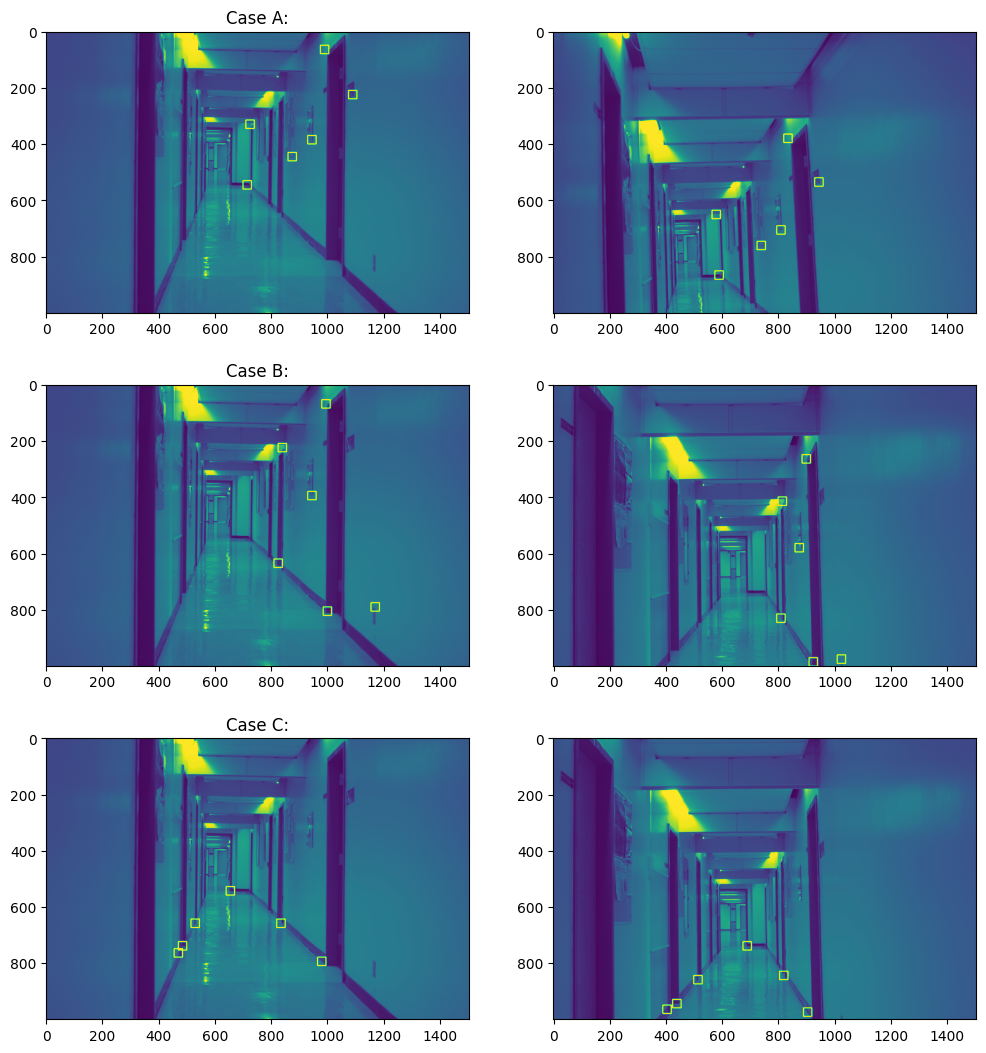

In [9]:
# Case A
A_gray1 = gray_img1.copy()
print(A_gray1.shape)
src_A, dst_A = points('A')
plot_pts(A_gray1, src_A, 'yellow')
A_gray2 = gray_img2.copy()
plot_pts(A_gray2, dst_A, 'yellow')
print(A_gray1.shape)
# Case B
B_gray1 = gray_img1.copy()
src_B, dst_B = points('B')
plot_pts(B_gray1, src_B, 'yellow')
B_gray3 = gray_img3.copy()
plot_pts(B_gray3, dst_B, 'yellow')
# Case C
C_gray1 = gray_img1.copy()
src_C, dst_C = points('C')
plot_pts(C_gray1, src_C, 'yellow')
C_gray3 = gray_img3.copy()
plot_pts(C_gray3, dst_C, 'yellow')
# plot
fig, axes = plt.subplots(3, 2, figsize=(12, 13))
axes[0][0].imshow(A_gray1)
axes[0][0].set_title("Case A:")
axes[1][0].set_title("Case B:")
axes[2][0].set_title("Case C:")
axes[0][1].imshow(A_gray2)
axes[1][0].imshow(B_gray1)
axes[1][1].imshow(B_gray3)
axes[2][0].imshow(C_gray1)
axes[2][1].imshow(C_gray3)

In [11]:
def homography_matrix(src_pts, dst_pts):

    A = []
    for i in range(len(src_pts)):
        x, y = src_pts[i]
        u, v = dst_pts[i]
        A.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
        A.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])
    A = np.array(A)

    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape((3, 3))
    
    return H

src_A, dst_A = points('A')
check = homography_matrix(src_A, dst_A)
print(check)
print('\n')
src_B, dst_B = points('B')
check2 = homography_matrix(src_B, dst_B)
print(check2)
print('\n')
src_C, dst_C = points('C')
check3 = homography_matrix(src_C, dst_C)
print(check3)


[[-2.55162336e-03 -2.15961103e-04  4.20141847e-01]
 [ 1.12669728e-04 -2.58950415e-03 -9.07447361e-01]
 [ 7.40639866e-08 -5.05755856e-08 -2.61521911e-03]]


[[-9.05841959e-04  7.22670768e-05 -7.96760626e-01]
 [ 2.33949336e-04 -1.74077697e-03 -6.04288193e-01]
 [ 1.99978582e-07  1.30867768e-07 -2.09125592e-03]]


[[ 1.29311552e-03 -9.19484146e-04  7.33206912e-01]
 [-3.57145663e-04  1.30496916e-03  6.79999775e-01]
 [-3.03181514e-07 -2.45602253e-07  1.89242140e-03]]


Text(0.5, 1.0, 'Case C:')

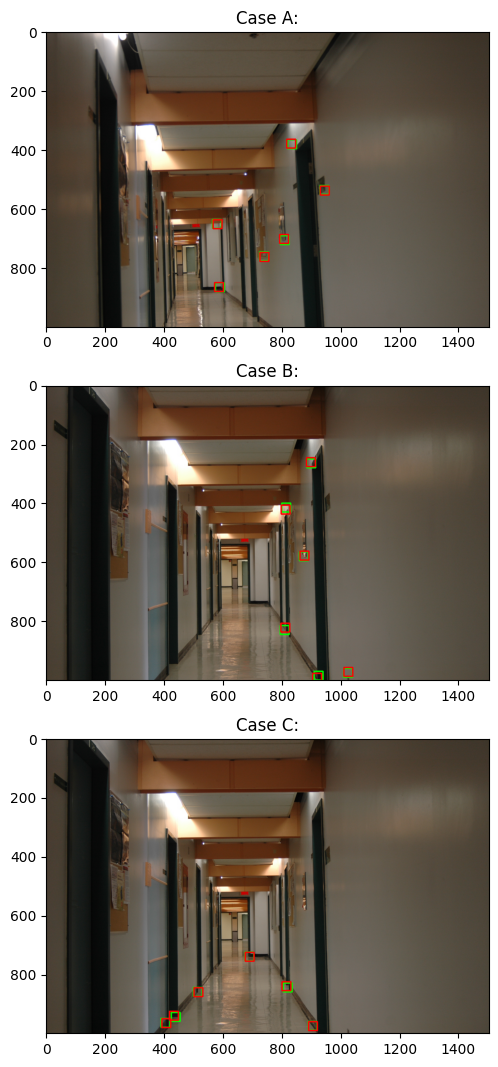

In [12]:
def get_proj_points(src_pts, dst_pts):
    H = homography_matrix(src_pts, dst_pts)
    src_pts_h = np.concatenate([src_pts, np.ones((len(src_pts), 1))], axis=1)
    proj_h = np.dot(src_pts_h, H.T)
    proj = proj_h[:, :2] / proj_h[:, 2:]
    proj = proj.astype(int) 
    return proj

# Case A
img2_A = img2.copy()
src_A, dst_A = points('A')
proj_A = get_proj_points(src_A, dst_A)
plot_pts(img2_A, dst_A, 'green')
plot_pts(img2_A, proj_A, 'red')

# Case B
img3_B = img3.copy()
src_B, dst_B = points('B')
proj_B = get_proj_points(src_B, dst_B)
plot_pts(img3_B, dst_B, 'green')
plot_pts(img3_B, proj_B, 'red')

# Case C
img3_C = img3.copy()
src_C, dst_C = points('C')
proj_C = get_proj_points(src_C, dst_C)
plot_pts(img3_C, dst_C, 'green')
plot_pts(img3_C, proj_C, 'red')


fig, axes = plt.subplots(3, 1, figsize=(12, 13))
axes[0].imshow(img2_A)
axes[1].imshow(img3_B)
axes[2].imshow(img3_C)
axes[0].set_title("Case A:")
axes[1].set_title("Case B:")
axes[2].set_title("Case C:")


Text(0.5, 1.0, 'Case C:')

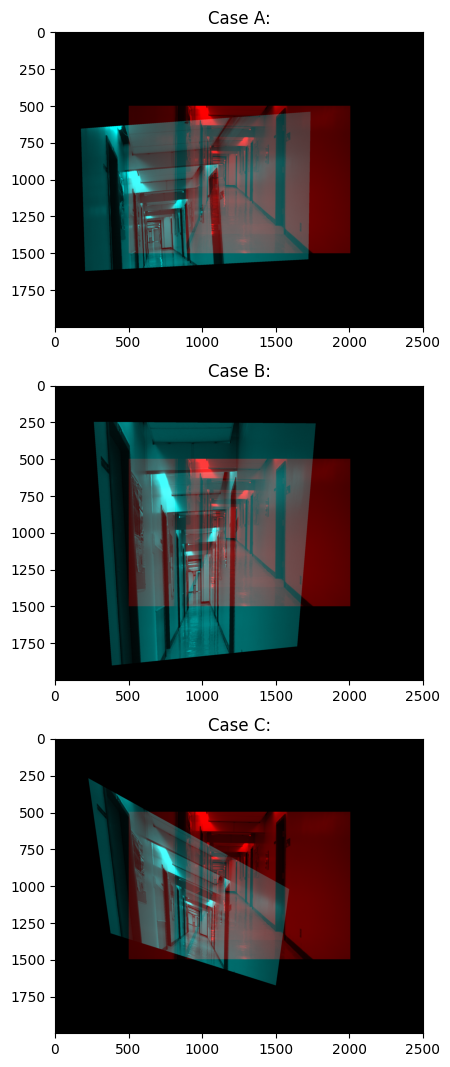

In [13]:

def check_domain(x, y, n, m, padding):
  if padding <= x <  n+padding and \
                    padding <= y < m+padding:  
    return True
  else:
    return False

def new_image(image1, image2, case):
  """
  """
  n,m = image1.shape
  
  padding = 500
  new_n, new_m = n + 2*padding, m + 2*padding
  new_image = np.zeros((new_n, new_m, 3))
  new_image[padding: padding+n, padding: padding+m, 0] = image1
  
  x, y = points(case)
  H = homography_matrix(x,y)
  
  for i in range(new_n): 
      for j in range(new_m):
        hom_point = np.array([i, j, 1])
        proj_point = H @ hom_point
        new_x = int(proj_point[0] / proj_point[2])
        new_y = int(proj_point[1] / proj_point[2])
        if check_domain(new_x, new_y, n, m, padding):
              new_image[i, j, 1] = image2[new_x - padding, new_y - padding]
              new_image[i, j, 2] = image2[new_x - padding, new_y - padding]
  
  
  new_image = new_image/255
  return new_image



image_A = new_image(gray_img1, gray_img2, 'A')
image_B = new_image(gray_img1, gray_img3, 'B')
image_C = new_image(gray_img1, gray_img3, 'C')

fig, axes = plt.subplots(3, 1, figsize=(12, 13))
axes[0].imshow(image_A)
axes[1].imshow(image_B)
axes[2].imshow(image_C)
axes[0].set_title("Case A:")
axes[1].set_title("Case B:")
axes[2].set_title("Case C:")

